In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run param.py

In [3]:
NG_REFS = PARAM['ng_refs']
P_REFS, T_REFS = zip(*PARAM['ref_pts'])

In [4]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'ng_adju',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin',
            'option_compute_ktable',
            'option_compute_btable']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [5]:
analysis = scripts.Analysis()

In [6]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_FORTRAN
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [7]:
def add_wgt_models():
    iggs = [10, 1]
    markers = [None, 'x']
    colors = ['r', 'c']
    linestyle = '-'

    df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                         'output_wfluxg.dat'), 
                            sep=r'\s+')

    df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wcoolrg.dat'), 
                             sep=r'\s+')

    for igg, marker, color in zip(iggs, markers, colors):

        flux_igg = df_wfluxg[df_wfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdx_igg = analysis.model('wgt_igg{}'.format(igg))
        crdx_igg.type_model = 'crd'
        crdx_igg.rundir = DIR_FORTRAN
        crdx_igg.fpath_flux = s_flux
        crdx_igg.fpath_coolr = s_coolr
        crdx_igg.color = color
        crdx_igg.marker = marker
        crdx_igg.linestyle = linestyle
        crdx_igg.load_data()
        
add_wgt_models()

In [8]:
def add_ktable_models():
    iggs = [10]
    markers = ['D',]
    color = 'g'
    linestyle = ':'

    df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wwfluxg.dat'), 
                             sep=r'\s+')

    df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                           'output_wwcoolrg.dat'), 
                              sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
        crdxx_igg.type_model = 'crd'
        crdxx_igg.rundir = DIR_FORTRAN
        crdxx_igg.fpath_flux = s_flux
        crdxx_igg.fpath_coolr = s_coolr
        crdxx_igg.color = color
        crdxx_igg.marker = marker
        crdxx_igg.linestyle = linestyle
        crdxx_igg.load_data()
        
        

In [9]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [10]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [11]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [12]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [13]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

c = c.split('stop')[0]

print('\n\n'.join(get_input_params(c, sorted(innames()))))

dv = 0.005

klin =2.22e-20

nband = 80

ng =10

ng_adju = (/ 0 /) 

ng_refs = (/ 4 , 6 /) 

nref =2

nv = 200

option_compute_btable =0

option_compute_ktable =0

option_klin =1

option_wgt_flux =2

option_wgt_k =1

p_refs = (/ 1 , 500 /) 

t_refs = (/ 250 , 250 /) 

tsfc =294

vstar = 540

data w_diffuse
     &     /1.66 , 1.66 , 1.66 , 1.66,
     &     1.66 , 1.66 , 1.66 , 1.66,
     &     1.66 , 1.66/

data wgt
     &     /1 , 1 , 1 , 1,
     &     1 , 1 , 1 , 1,
     &     1 , 1/

atmosphere_profiles/mls75.pro


In [14]:
fig.display_hrefanchor()

In [15]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [16]:
table_dgdgs.display_hrefanchor()

In [17]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [18]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [19]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

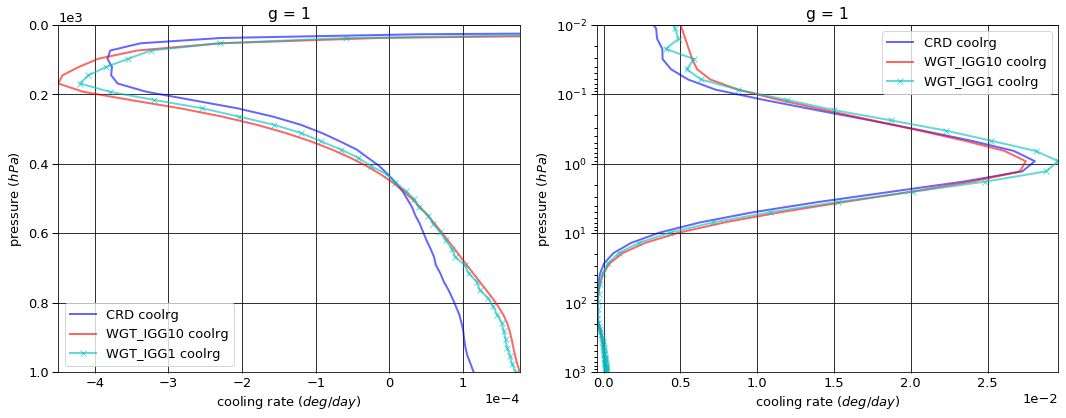

# Figure: cooling rate g-group 2

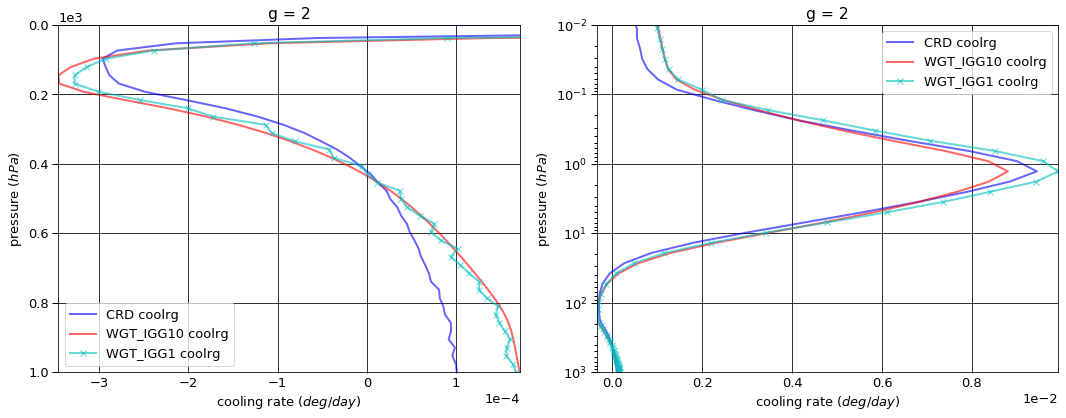

# Figure: cooling rate g-group 3

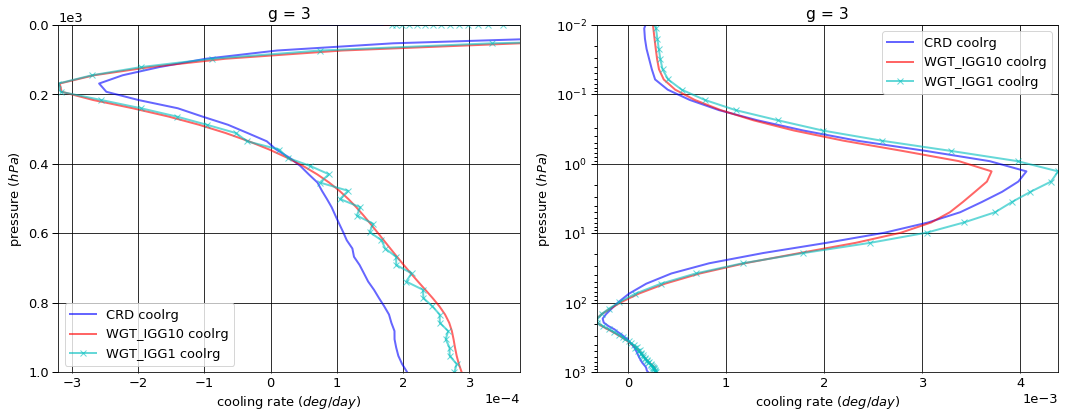

# Figure: cooling rate g-group 4

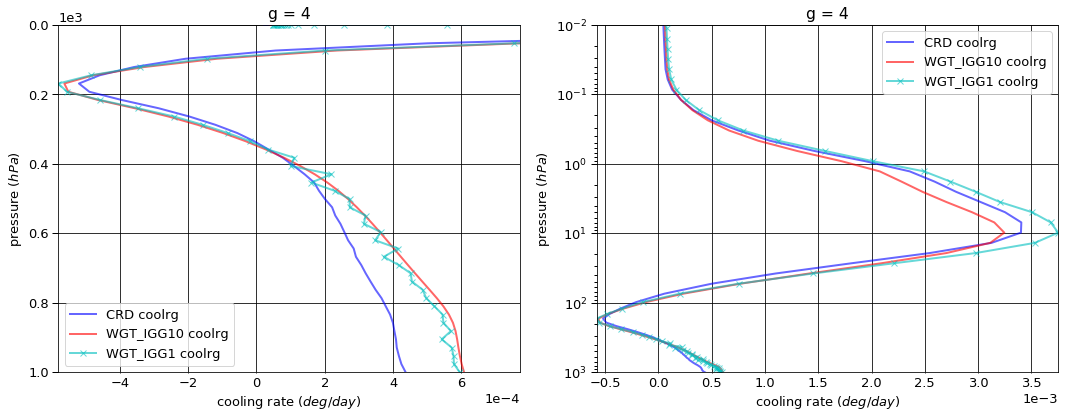

# Figure: cooling rate g-group 5

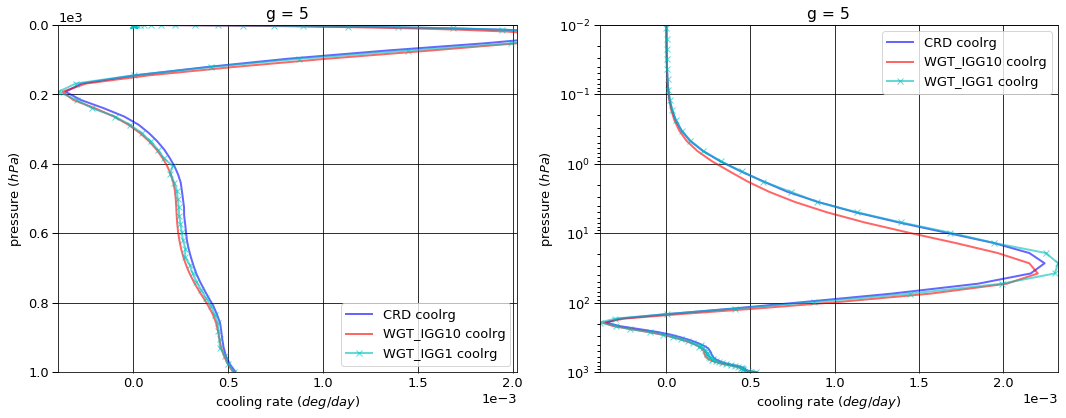

# Figure: cooling rate g-group 6

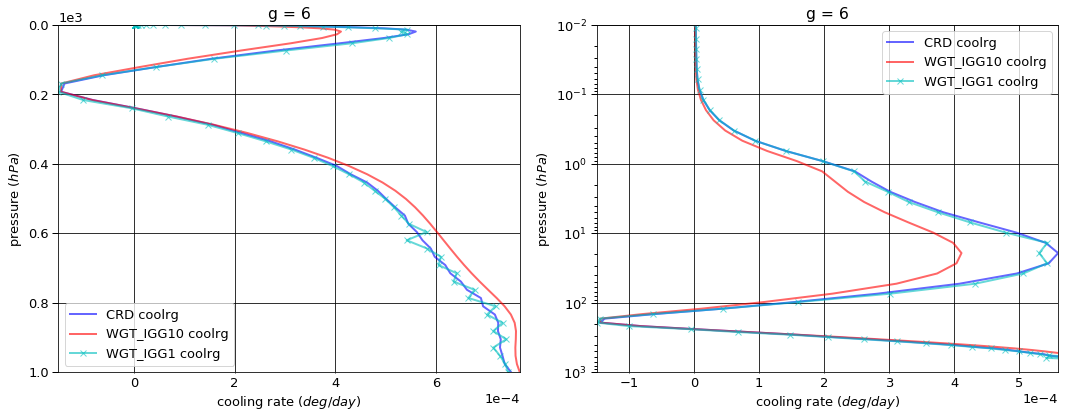

# Figure: cooling rate g-group 7

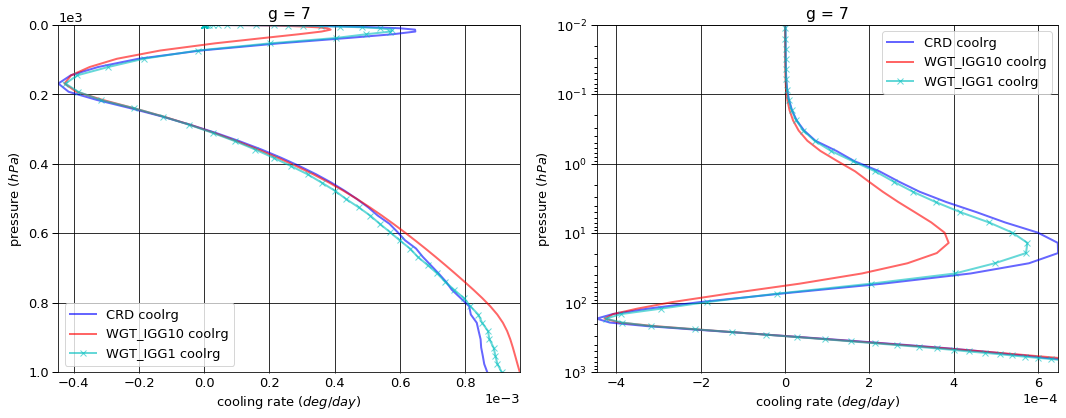

# Figure: cooling rate g-group 8

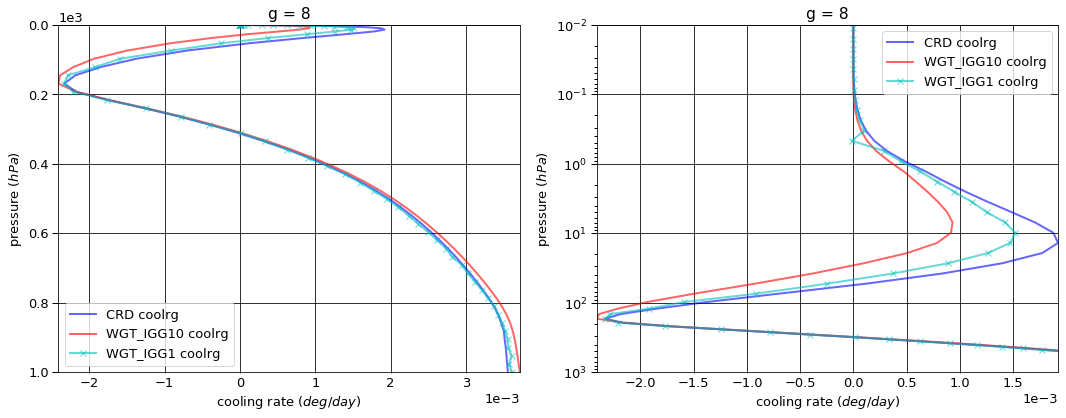

# Figure: cooling rate g-group 9

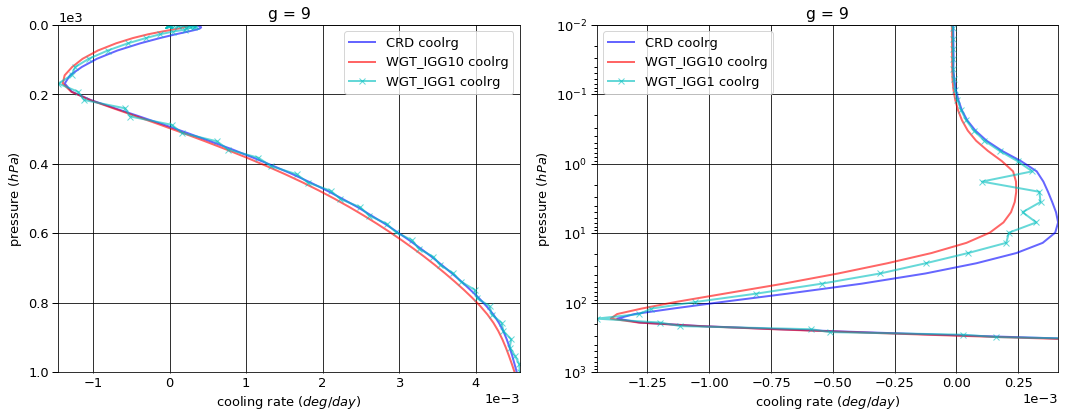

# Figure: cooling rate g-group 10

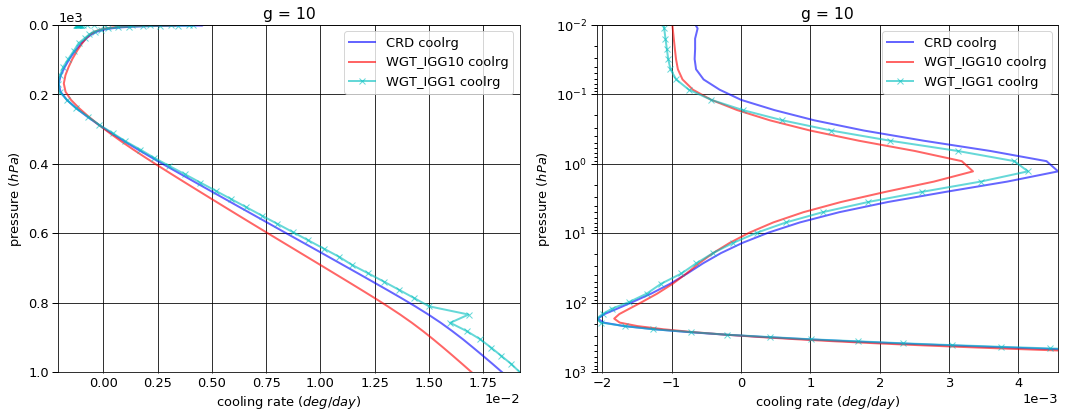

# Figure: cooling rate g-group total

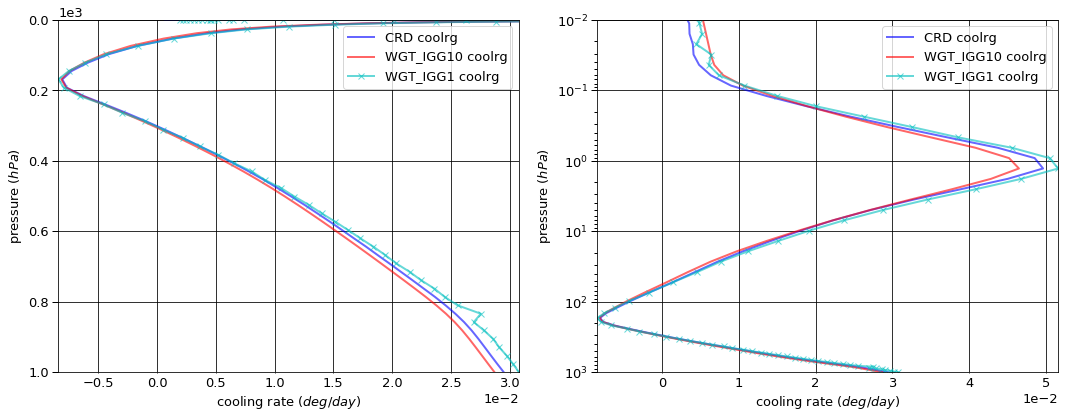

In [20]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [21]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug      fldg      fnetg
g  pressure level                                
1  0.0      1      -0.024445  0.000000  -0.024445
   1013.0   76     -0.043070  0.029479  -0.013590
2  0.0      1      -0.025424  0.000000  -0.025424
   1013.0   76     -0.043048  0.023817  -0.019231
3  0.0      1      -0.038568  0.000000  -0.038568
   1013.0   76     -0.065756  0.041256  -0.024500
4  0.0      1      -0.074169  0.000000  -0.074169
   1013.0   76     -0.131501  0.083836  -0.047665
5  0.0      1      -0.058855  0.000000  -0.058855
   1013.0   76     -0.138346  0.125082  -0.013264
6  0.0      1      -0.085196  0.000000  -0.085196
   1013.0   76     -0.147414  0.114810  -0.032604
7  0.0      1      -0.132500  0.000000  -0.132500
   1013.0   76     -0.194924  0.108883  -0.086041
8  0.0      1      -1.040331  0.000000  -1.040331
   1013.0   76     -1.327691  0.463150  -0.864541
9  0.0      1      -1.889153  0.000000  -1.889153
   1013.0   76     -2.098085  0.439976  -1.658108
10 0.0      1     -31.649889  0.000000 -31.649889
   1013.0   76    -32.045573  1.183706 -30.861868


WGT_IGG10


flug      fldg      fnetg
g  pressure level                                
1  0.0      1      -0.022284  0.000000  -0.022284
   1013.0   76     -0.043070  0.035943  -0.007127
2  0.0      1      -0.021485  0.000000  -0.021485
   1013.0   76     -0.043048  0.030936  -0.012112
3  0.0      1      -0.030586  0.000000  -0.030586
   1013.0   76     -0.065756  0.054337  -0.011419
4  0.0      1      -0.062780  0.000000  -0.062780
   1013.0   76     -0.131501  0.105141  -0.026360
5  0.0      1      -0.054943  0.000000  -0.054943
   1013.0   76     -0.138346  0.127445  -0.010901
6  0.0      1      -0.082009  0.000000  -0.082009
   1013.0   76     -0.147414  0.119392  -0.028022
7  0.0      1      -0.129386  0.000000  -0.129386
   1013.0   76     -0.194924  0.113228  -0.081696
8  0.0      1      -1.033716  0.000000  -1.033716
   1013.0   76     -1.327691  0.464043  -0.863648
9  0.0      1      -1.900958  0.000000  -1.900958
   1013.0   76     -2.098085  0.416855  -1.681230
10 0.0      1     -31.703634  0.000000 -31.703634
   1013.0   76    -32.045573  1.057322 -30.988252


WGT_IGG1


flug      fldg      fnetg
g  pressure level                                
1  0.0      1      -0.022808  0.000000  -0.022808
   1013.0   76     -0.043070  0.035310  -0.007760
2  0.0      1      -0.022468  0.000000  -0.022468
   1013.0   76     -0.043048  0.030308  -0.012740
3  0.0      1      -0.031945  0.000000  -0.031945
   1013.0   76     -0.065756  0.053072  -0.012684
4  0.0      1      -0.065353  0.000000  -0.065353
   1013.0   76     -0.131501  0.102485  -0.029016
5  0.0      1      -0.056924  0.000000  -0.056924
   1013.0   76     -0.138346  0.125725  -0.012622
6  0.0      1      -0.083675  0.000000  -0.083675
   1013.0   76     -0.147414  0.115953  -0.031461
7  0.0      1      -0.130011  0.000000  -0.130011
   1013.0   76     -0.194924  0.111092  -0.083832
8  0.0      1      -1.026080  0.000000  -1.026080
   1013.0   76     -1.327691  0.472170  -0.855521
9  0.0      1      -1.883593  0.000000  -1.883593
   1013.0   76     -2.098085  0.444497  -1.653587
10 0.0      1     -31.643891  0.000000 -31.643891
   1013.0   76    -32.045573  1.228657 -30.816916


WGT_IGG10 - CRD


flug      fldg     fnetg
g  pressure level                                  
1  0.0      1      2.160363e-03  0.000000  0.002160
   1013.0   76     0.000000e+00  0.006464  0.006464
2  0.0      1      3.938153e-03  0.000000  0.003938
   1013.0   76     0.000000e+00  0.007119  0.007119
3  0.0      1      7.982300e-03  0.000000  0.007982
   1013.0   76     0.000000e+00  0.013080  0.013080
4  0.0      1      1.138842e-02  0.000000  0.011388
   1013.0   76     0.000000e+00  0.021305  0.021305
5  0.0      1      3.911916e-03  0.000000  0.003912
   1013.0   76     0.000000e+00  0.002363  0.002363
6  0.0      1      3.186790e-03  0.000000  0.003187
   1013.0   76     0.000000e+00  0.004582  0.004582
7  0.0      1      3.113840e-03  0.000000  0.003114
   1013.0   76     0.000000e+00  0.004345  0.004345
8  0.0      1      6.615000e-03  0.000000  0.006615
   1013.0   76     2.220446e-16  0.000893  0.000893
9  0.0      1     -1.180480e-02  0.000000 -0.011805
   1013.0   76     0.000000e+00 -0.023121 -0.023121
10 0.0      1     -5.374500e-02  0.000000 -0.053745
   1013.0   76     0.000000e+00 -0.126384 -0.126384


WGT_IGG1 - CRD


flug      fldg     fnetg
g  pressure level                                  
1  0.0      1      1.636725e-03  0.000000  0.001637
   1013.0   76     0.000000e+00  0.005830  0.005830
2  0.0      1      2.955313e-03  0.000000  0.002955
   1013.0   76     0.000000e+00  0.006491  0.006491
3  0.0      1      6.623576e-03  0.000000  0.006624
   1013.0   76     0.000000e+00  0.011816  0.011816
4  0.0      1      8.815459e-03  0.000000  0.008815
   1013.0   76     0.000000e+00  0.018649  0.018649
5  0.0      1      1.931003e-03  0.000000  0.001931
   1013.0   76     0.000000e+00  0.000642  0.000642
6  0.0      1      1.520574e-03  0.000000  0.001521
   1013.0   76     0.000000e+00  0.001143  0.001143
7  0.0      1      2.488810e-03  0.000000  0.002489
   1013.0   76     0.000000e+00  0.002209  0.002209
8  0.0      1      1.425150e-02  0.000000  0.014251
   1013.0   76     2.220446e-16  0.009020  0.009020
9  0.0      1      5.559500e-03  0.000000  0.005559
   1013.0   76     0.000000e+00  0.004521  0.004521
10 0.0      1      5.998000e-03  0.000000  0.005998
   1013.0   76     0.000000e+00  0.044952  0.044952

# Table: cooling rate. g-groups 


CRD


coolrg
g  pressure    layer              
1  0.000312    1      1.203298e-03
   1001.112500 75     1.144719e-04
2  0.000312    1      3.964364e-04
   1001.112500 75     1.010829e-04
3  0.000312    1      7.392946e-05
   1001.112500 75     2.065717e-04
4  0.000312    1      2.231802e-05
   1001.112500 75     4.365946e-04
5  0.000312    1      1.018473e-06
   1001.112500 75     5.408862e-04
6  0.000312    1      1.118463e-06
   1001.112500 75     7.492716e-04
7  0.000312    1      1.106551e-08
   1001.112500 75     8.677223e-04
8  0.000312    1     -1.726973e-06
   1001.112500 75     3.558419e-03
9  0.000312    1     -1.659659e-05
   1001.112500 75     4.539128e-03
10 0.000312    1     -8.476278e-04
   1001.112500 75     1.838211e-02


WGT_IGG10


coolrg
g  pressure    layer              
1  0.000312    1      3.195128e-03
   1001.112500 75     1.770049e-04
2  0.000312    1      6.616290e-04
   1001.112500 75     1.717090e-04
3  0.000312    1      1.723134e-04
   1001.112500 75     2.888584e-04
4  0.000312    1      3.880924e-05
   1001.112500 75     6.075947e-04
5  0.000312    1      1.153790e-06
   1001.112500 75     5.272206e-04
6  0.000312    1      5.985589e-07
   1001.112500 75     7.665696e-04
7  0.000312    1     -5.037765e-07
   1001.112500 75     9.673858e-04
8  0.000312    1     -2.210332e-06
   1001.112500 75     3.717701e-03
9  0.000312    1     -2.078841e-05
   1001.112500 75     4.510234e-03
10 0.000312    1     -1.095014e-03
   1001.112500 75     1.697610e-02


WGT_IGG1


coolrg
g  pressure    layer              
1  0.000312    1      2.425518e-03
   1001.112500 75     1.719664e-04
2  0.000312    1      5.715367e-04
   1001.112500 75     1.678067e-04
3  0.000312    1      1.838552e-04
   1001.112500 75     2.777249e-04
4  0.000312    1      4.725061e-05
   1001.112500 75     5.949807e-04
5  0.000312    1      1.339956e-06
   1001.112500 75     5.326493e-04
6  0.000312    1      1.349584e-06
   1001.112500 75     7.436314e-04
7  0.000312    1      6.591687e-08
   1001.112500 75     9.122162e-04
8  0.000312    1     -1.339830e-06
   1001.112500 75     3.612606e-03
9  0.000312    1     -1.829887e-05
   1001.112500 75     4.578622e-03
10 0.000312    1     -1.243910e-03
   1001.112500 75     1.919517e-02


WGT_IGG10 - CRD


coolrg
g  pressure    layer              
1  0.000312    1      1.991830e-03
   1001.112500 75     6.253306e-05
2  0.000312    1      2.651926e-04
   1001.112500 75     7.062612e-05
3  0.000312    1      9.838390e-05
   1001.112500 75     8.228664e-05
4  0.000312    1      1.649122e-05
   1001.112500 75     1.710001e-04
5  0.000312    1      1.353175e-07
   1001.112500 75    -1.366554e-05
6  0.000312    1     -5.199042e-07
   1001.112500 75     1.729796e-05
7  0.000312    1     -5.148420e-07
   1001.112500 75     9.966352e-05
8  0.000312    1     -4.833582e-07
   1001.112500 75     1.592822e-04
9  0.000312    1     -4.191826e-06
   1001.112500 75    -2.889370e-05
10 0.000312    1     -2.473866e-04
   1001.112500 75    -1.406006e-03


WGT_IGG1 - CRD


coolrg
g  pressure    layer              
1  0.000312    1      1.222220e-03
   1001.112500 75     5.749456e-05
2  0.000312    1      1.751003e-04
   1001.112500 75     6.672373e-05
3  0.000312    1      1.099257e-04
   1001.112500 75     7.115319e-05
4  0.000312    1      2.493259e-05
   1001.112500 75     1.583862e-04
5  0.000312    1      3.214834e-07
   1001.112500 75    -8.236850e-06
6  0.000312    1      2.311205e-07
   1001.112500 75    -5.640240e-06
7  0.000312    1      5.485136e-08
   1001.112500 75     4.449392e-05
8  0.000312    1      3.871428e-07
   1001.112500 75     5.418780e-05
9  0.000312    1     -1.702287e-06
   1001.112500 75     3.949430e-05
10 0.000312    1     -3.962818e-04
   1001.112500 75     8.130570e-04

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-35.018529,0.000000,-35.018529
1013.0,76,-36.235408,2.613995,-33.621413



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-35.041782,0.000000,-35.041782
1013.0,76,-36.235408,2.524641,-33.710767



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-34.966748,0.000000,-34.966748
1013.0,76,-36.235408,2.719269,-33.516139



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-0.023253,0.000000,-0.023253
1013.0,76,0.000000,-0.089354,-0.089354



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.05178,0.000000,0.051780
1013.0,76,0.00000,0.105274,0.105274


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,0.000832
1001.112500,75,0.029496



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,0.002951
1001.112500,75,0.028710



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,0.001967
1001.112500,75,0.030787



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.002119
1001.112500,75,-0.000786



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.001135
1001.112500,75,0.001291


In [22]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.001187,0.001179
2,0.001187,0.001176
3,0.001813,0.001805
4,0.003625,0.003605
5,0.003812,0.003791
6,0.004063,0.004039
7,0.005375,0.005323
8,0.036625,0.036263
9,0.057875,0.057421


In [23]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,3.927095e-18
2,9.495772e-19
3,2.296091e-19
4,5.551982e-20
5,4.010048e-19
6,1.945212e-19
7,9.435918e-20
8,4.577217e-20
9,2.220337e-20


In [24]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [25]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,3.927095e-18,NaN,0.001187,0.001179,0.001187,0.001179,1.0
2,9.495772e-19,0.241801,0.001187,0.001176,0.002375,0.002355,1.0
3,2.296091e-19,0.241801,0.001813,0.001805,0.004188,0.004160,1.0
4,5.551982e-20,0.241801,0.003625,0.003605,0.007812,0.007766,1.0
5,4.010048e-19,7.222731,0.003812,0.003791,0.011625,0.011557,500.0
6,1.945212e-19,0.485084,0.004063,0.004039,0.015688,0.015596,500.0
7,9.435918e-20,0.485084,0.005375,0.005323,0.021062,0.020918,500.0
8,4.577217e-20,0.485084,0.036625,0.036263,0.057687,0.057181,500.0
9,2.220337e-20,0.485084,0.057875,0.057421,0.115562,0.114602,500.0


In [26]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
